<a href="https://colab.research.google.com/github/lorenzflow/MachineLearning/blob/main/Insta_captions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer Learning to generate instagram image captions

# Install kaggle api and load dataset

In [1]:

import pandas as pd
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import tensorflow_hub as hub
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from pickle import dump

In [25]:
import random

In [2]:
!pip install syft

     |████████████████████████████████| 606 kB 7.5 MB/s 
     |████████████████████████████████| 25.5 MB 1.5 MB/s 
     |████████████████████████████████| 40 kB 6.0 MB/s 
     |████████████████████████████████| 11.3 MB 24.6 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 789 kB 49.5 MB/s 
     |████████████████████████████████| 961 kB 51.7 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 74.8 MB/s 
     |████████████████████████████████| 6.2 MB 21.5 MB/s 
     |████████████████████████████████| 61 kB 487 kB/s 
     |████████████████████████████████| 15.7 MB 7.1 MB/s 
     |████████████████████████████████| 1.6 MB 43.4 MB/s 
     |████████████████████████████████| 10.1 MB 20.5 MB/s 
     |████████████████████████████████| 62 kB 928 kB/s 
     |████████████████████████████████| 5.8 MB 59.1 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |███████████████████

In [2]:
!pip install kaggle # install kaggle from where we take the data set

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lorenz75","key":"9178b7409d384b4af53ef1c702338188"}'}

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18974  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11563  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5940  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           4029  
promptcloud/car

In [6]:
! kaggle datasets list -s [Instagram]

ref                                                         title                                            size  lastUpdated          downloadCount  
----------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  
free4ever1/instagram-fake-spammer-genuine-accounts          Instagram fake spammer genuine accounts           7KB  2019-03-22 15:12:51           3156  
zusmani/pakistans-top-25-instagram-accounts                 Pakistan's Top 25 Instagram Accounts             642B  2021-05-12 04:11:04             96  
mrmorj/us-politicians-twitter-dataset                       US Politicians Twitter Dataset                   68KB  2020-11-23 09:54:05           1476  
prithvijaunjale/instagram-images-with-captions              Instagram Images with Captions                    4GB  2020-03-21 11:34:12            661  
onurserbetci/nba-instagram-data                             NBA Instagram Data          

In [5]:
! kaggle datasets download -d prithvijaunjale/instagram-images-with-captions

100% 3.84G/3.84G [01:03<00:00, 39.4MB/s]
100% 3.84G/3.84G [01:03<00:00, 64.7MB/s]


In [8]:
! mkdir insta

In [9]:
! ls

insta  instagram-images-with-captions.zip  sample_data


In [6]:
! unzip instagram-images-with-captions.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: instagram_data2/img2/insta29928.jpg  
  inflating: instagram_data2/img2/insta29929.jpg  
  inflating: instagram_data2/img2/insta29930.jpg  
  inflating: instagram_data2/img2/insta29931.jpg  
  inflating: instagram_data2/img2/insta29932.jpg  
  inflating: instagram_data2/img2/insta29933.jpg  
  inflating: instagram_data2/img2/insta29934.jpg  
  inflating: instagram_data2/img2/insta29935.jpg  
  inflating: instagram_data2/img2/insta29936.jpg  
  inflating: instagram_data2/img2/insta29937.jpg  
  inflating: instagram_data2/img2/insta29938.jpg  
  inflating: instagram_data2/img2/insta29939.jpg  
  inflating: instagram_data2/img2/insta29940.jpg  
  inflating: instagram_data2/img2/insta29941.jpg  
  inflating: instagram_data2/img2/insta29942.jpg  
  inflating: instagram_data2/img2/insta29943.jpg  
  inflating: instagram_data2/img2/insta29944.jpg  
  inflating: instagram_data2/img2/insta29945.jpg  
  inflating: in

In [7]:
! ls instagram_data

captions_csv.csv  img


## Check out captions
Let us have a look at the captions_csv.csv file. We will use the Image File column to map captions to images. Secondly, note how some captions are missing ('NAN'). This is the case for 3415 images in the data set. We will use these images to see if out model can come up with reasonable captions for them.

In [8]:
captions = pd.read_csv('instagram_data/captions_csv.csv')

In [13]:
captions.head()

,Sr No,Image File,Caption
0,1,img/insta1,NaN
1,2,img/insta2,bye
2,3,img/insta3,"Ok, a few more... sorry I just had so much fun..."
3,4,img/insta4,This was one of my favorite shoots I’ve ever d...
4,5,img/insta5,Wrapped round my finger like a ring


In [14]:
np.sum(captions['Caption'].isna())

3415

In [9]:
# time to split into images with captions and images without caption

images_with_caption = captions[captions['Caption'].notna()]['Image File'].values
images_without_caption = captions[captions['Caption'].isna()]['Image File'].values
y_train = captions[captions['Caption'].notna()]['Caption']

In [ ]:
y_train[200]

'FETISH '

## Load Images

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [11]:
train_names = ['instagram_data/' + x + '.jpg' for x in images_with_caption]
test_names = ['instagram_data/' + x + '.jpg' for x in images_without_caption]

In [ ]:
#img = load_img(file_names[0], target_size=(299,299))

In [146]:
#img = img_to_array(img)
#img.shape
print(y_train[1000])

Sporty spice. Werd. 


## Transfer learning

### Initialise the feature extractor

As feature extractor we will use the inception_v3 model trained on the imagenet dataset. We will remove the final layer to obtain the feature vector output by the last convolutional layer.

In [12]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


### Extract the features and save features as batched dataset

In [13]:
!pip install tqdm
from tqdm import tqdm

In [14]:
train_image_dataset = tf.data.Dataset.from_tensor_slices(train_names)
train_image_dataset = train_image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(train_image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 1069/1069 [05:12<00:00,  3.42it/s]


### Preprocess and tokenize the captions

- split the captions into words, preserving character combinations such as emojis

- using most common character combinations as vocabulary and tokenizing the captions

In [85]:
caption_dataset = tf.data.Dataset.from_tensor_slices(y_train)

# Max word count for a caption, short for instagram captions incl hashtags
max_length = 8
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None, # no standardization to preserve punctuation eg emojis
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [86]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [87]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

# Train Val Test split

In [88]:
img_to_cap_vector = {}
for img, cap in zip(train_names, cap_vector):
  img_to_cap_vector[img] = cap

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  
  img_name_train.extend([imgt])
  cap_train.extend([img_to_cap_vector[imgt]])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  img_name_val.extend([imgv])
  cap_val.extend([img_to_cap_vector[imgv]])

In [89]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(13680, 13680, 3420, 3420)

## Create the data set for training

In [71]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [72]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [90]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## The Model

In [91]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [92]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [93]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [104]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [103]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [96]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [98]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [99]:
loss_plot = []

In [105]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [46]:
import time

In [107]:
EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 5 Batch 0 Loss 4.1661
Epoch 5 Batch 100 Loss 2.6808
Epoch 5 Batch 200 Loss 2.6196
Epoch 5 Loss 2.930031
Time taken for 1 epoch 133.73 sec

Epoch 6 Batch 0 Loss 3.0215
Epoch 6 Batch 100 Loss 2.4055
Epoch 6 Batch 200 Loss 2.8478
Epoch 6 Loss 2.681593
Time taken for 1 epoch 148.20 sec

Epoch 7 Batch 0 Loss 2.5745
Epoch 7 Batch 100 Loss 2.6519
Epoch 7 Batch 200 Loss 2.3193
Epoch 7 Loss 2.536125
Time taken for 1 epoch 170.36 sec

Epoch 8 Batch 0 Loss 2.9722
Epoch 8 Batch 100 Loss 2.0310
Epoch 8 Batch 200 Loss 2.1817
Epoch 8 Loss 2.393278
Time taken for 1 epoch 170.37 sec

Epoch 9 Batch 0 Loss 2.4494
Epoch 9 Batch 100 Loss 1.8454
Epoch 9 Batch 200 Loss 2.3011
Epoch 9 Loss 2.244774
Time taken for 1 epoch 170.38 sec

Epoch 10 Batch 0 Loss 2.4395
Epoch 10 Batch 100 Loss 2.2377
Epoch 10 Batch 200 Loss 2.0360
Epoch 10 Loss 2.100272
Time taken for 1 epoch 170.26 sec

Epoch 11 Batch 0 Loss 2.3424
Epoch 11 Batch 100 Loss 1.9981
Epoch 11 Batch 200 Loss 1.7521
Epoch 11 Loss 1.952653
Time taken f

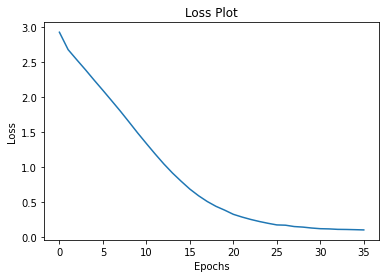

In [108]:
import matplotlib.pyplot as plt

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [61]:
# should continue training
print(ckpt_manager.checkpoints)

['./checkpoints/train/ckpt-1', './checkpoints/train/ckpt-2', './checkpoints/train/ckpt-3', './checkpoints/train/ckpt-4']


## Evaluation

In [53]:
from PIL import Image

In [109]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [110]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: welcome the to the family! First stop ..
Prediction Caption: [UNK] [UNK] [UNK] of the new [UNK] [UNK]


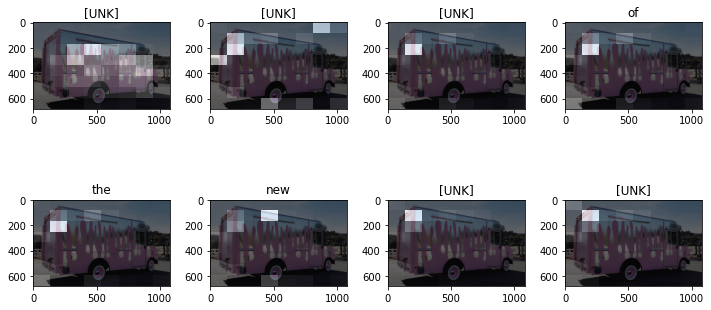

In [152]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)